# PRACTICA LogNASA con SQL

## Autor: Lucía Saiz Lapique

### Enunciado:

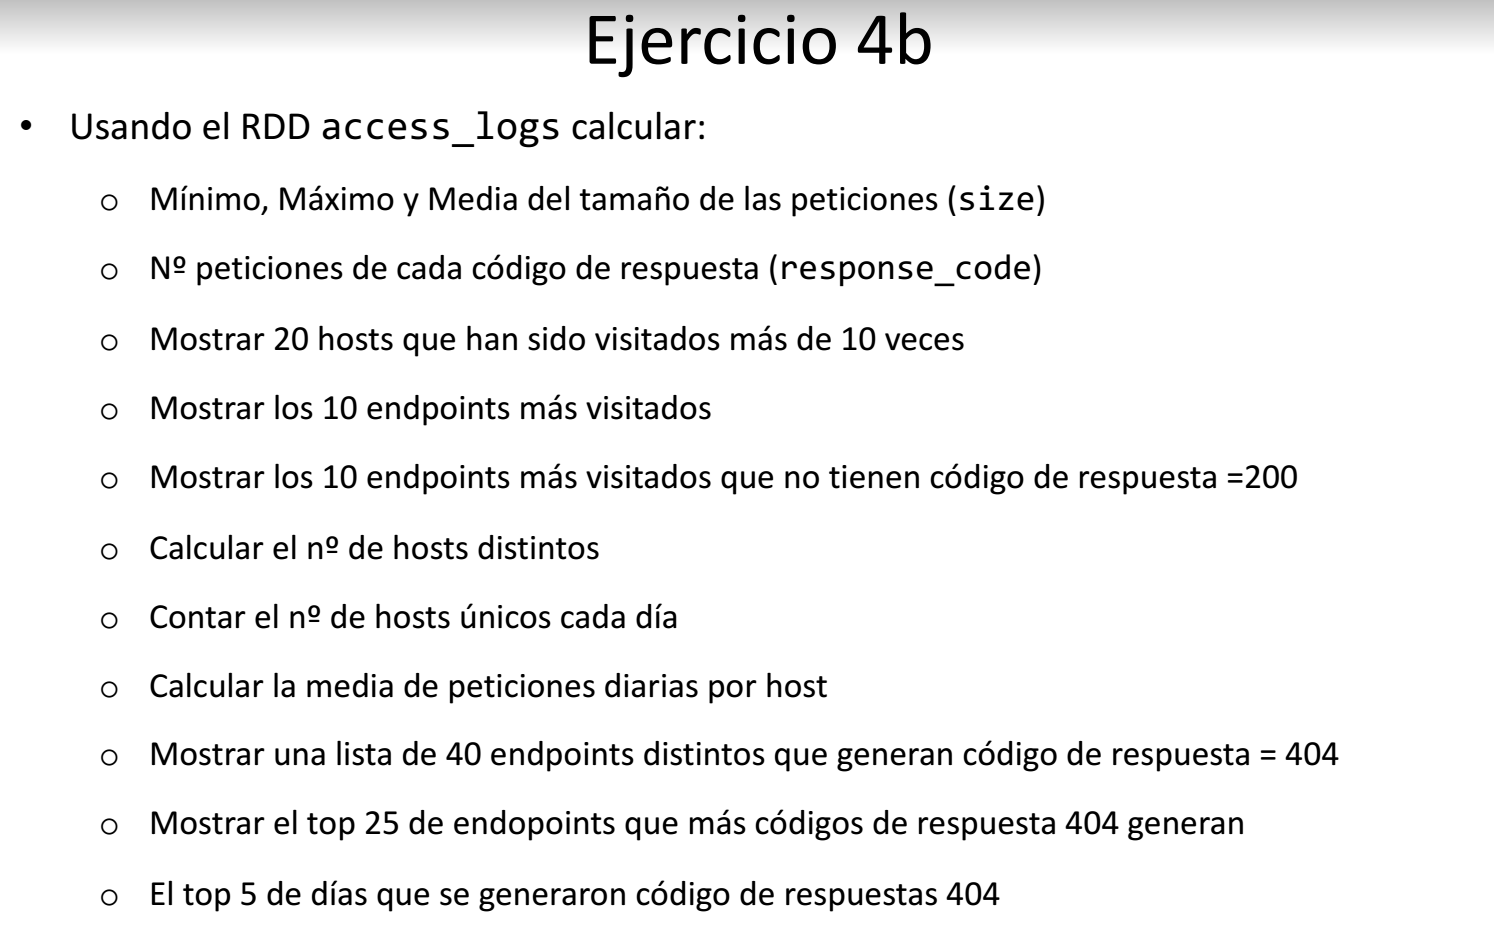

In [48]:
# importamos la imagen con el enunciado del ejercicio
from PIL import Image
i = Image.open('Ejercicio4b.jpg') 
i

In [49]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [50]:
data = "./apache.access.log_small"  #  usamos el dataset pequeño para que el codigo se nos ejecute mas rapido, pero debe 
# funcionar igual con el grande 
data = sc.textFile(data).cache()

In [51]:
data.take(5)

['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0']

In [52]:
data.count()

3432

In [53]:
import re  # este paquete nos permite parsear los datos con regresiones

In [54]:
def parse_log2(line): # parseamos los datos como en clase
    match = re.search('^(\S+) (\S+) (\S+) \[(\S+) [-](\d{4})\] "(\S+)\s*(\S+)\s*(\S+)\s*([/\w\.\s*]+)?\s*"* (\d{3}) (\S+)',line)
    if match is None:
        match = re.search('^(\S+) (\S+) (\S+) \[(\S+) [-](\d{4})\] "(\S+)\s*([/\w\.]+)>*([\w/\s\.]+)\s*(\S+)\s*(\d{3})\s*(\S+)',line)
    if match is None:
        return (line, 0)
    else:
        return (line, 1)

In [55]:
def map_log(line): 
    match = re.search('^(\S+) (\S+) (\S+) \[(\S+) [-](\d{4})\] "(\S+)\s*(\S+)\s*(\S+)\s*([/\w\.\s*]+)?\s*"* (\d{3}) (\S+)',line)
    if match is None:
        match = re.search('^(\S+) (\S+) (\S+) \[(\S+) [-](\d{4})\] "(\S+)\s*([/\w\.]+)>*([\w/\s\.]+)\s*(\S+)\s*(\d{3})\s*(\S+)',line)
    return(match.groups())
parsed_rdd = data.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0]) #map con el segundo parseador, filtramos cuales de ellos han sido uno (que el paseador los pasa adecuadamente) y despues mapeamos
parsed_def = parsed_rdd.map(lambda line: map_log(line))

In [56]:
parsed_def.take(1)

[('in24.inetnebr.com',
  '-',
  '-',
  '01/Aug/1995:00:00:01',
  '0400',
  'GET',
  '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt',
  'HTTP/1.0"',
  None,
  '200',
  '1839')]

In [57]:
from pyspark.sql import SQLContext, Row # Row nos permite darle nombres a cada elemento de la lista
from pyspark.sql.functions import *
sqlContext = SQLContext(sc)  # esta es la funcion que necesitanmos para ejecutar SQL en pyspark

In [58]:
def convert_long(x):  
    x = re.sub('[^0-9]',"",x) 
    if x =="":
        return 0
    else:
        return int(x)

In [59]:
sql_data = parsed_def.map(lambda p: Row( # introducimos los datos parseados y les adjudicamos una columna a cada uno en el dataset. 
    Host = p[0], 
    date = p[3][:2],  # eliminamos la fecha entera y nos quedamos solo con el dia porque generaba error
    endpoint = p[6], 
    code = p[9],
    size = convert_long(p[10]))) # usamos la funcion convert long para evitar datos nulos

In [60]:
sql_data.take(1)

[Row(Host='in24.inetnebr.com', code='200', date='01', endpoint='/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', size=1839)]

In [61]:
df = sqlContext.createDataFrame(sql_data)
df.registerTempTable("nasa")  # le ponemos un nombremas facil de utilizar a nuestra base de datos para usarla con SQL

In [62]:
result = sqlContext.sql("""
    SELECT * 
    FROM nasa 
    LIMIT 20
""")
result.show()  # para comprobar que los datos estan correctamente introducidos y que el dataset esta creado como queremos, 
# pedimos 20 muestras del aspecto que tiene "nasa".

+--------------------+----+----+--------------------+-----+
|                Host|code|date|            endpoint| size|
+--------------------+----+----+--------------------+-----+
|   in24.inetnebr.com| 200|  01|/shuttle/missions...| 1839|
|     uplherc.upl.com| 304|  01|                   /|    0|
|     uplherc.upl.com| 304|  01|/images/ksclogo-m...|    0|
|     uplherc.upl.com| 304|  01|/images/MOSAIC-lo...|    0|
|     uplherc.upl.com| 304|  01|/images/USA-logos...|    0|
|ix-esc-ca2-07.ix....| 200|  01|/images/launch-lo...| 1713|
|     uplherc.upl.com| 304|  01|/images/WORLD-log...|    0|
|slppp6.intermind.net| 200|  01|/history/skylab/s...| 1687|
|piweba4y.prodigy.com| 200|  01|/images/launchmed...|11853|
|slppp6.intermind.net| 200|  01|/history/skylab/s...| 9202|
|slppp6.intermind.net| 200|  01|/images/ksclogosm...| 3635|
|ix-esc-ca2-07.ix....| 200|  01|/history/apollo/i...| 1173|
|slppp6.intermind.net| 200|  01|/history/apollo/i...| 3047|
|     uplherc.upl.com| 304|  01|/images/

## EJERCICIO 1: Mínimo, máximo y media del tamaño de las peticiones (size)

In [63]:
resultado1 = sqlContext.sql("""
    SELECT MIN(size) AS Minimo, MAX(size) AS Maximo, ROUND(AVG(size), 2) AS Media 
    FROM nasa 
""")
resultado1.show()  # podemos ejecutar MAXm MIN y AVG en la misma linea con el select. 

+------+------+--------+
|Minimo|Maximo|   Media|
+------+------+--------+
|     0|887988|16051.86|
+------+------+--------+



## EJERCICIO 2: Número de peticiones (size) de cada código de respuesta (response_code)

In [64]:
resultado2 = sqlContext.sql(""" 
    SELECT COUNT(size) AS Peticiones, code AS Codigo 
    FROM nasa 
    GROUP BY code
""")
resultado2.show() # la funcion count nos cuenta cuantos valores hay de la variable que le introducimos, y los agrupamos por codigo

+----------+------+
|Peticiones|Codigo|
+----------+------+
|      3140|   200|
|        50|   302|
|        22|   404|
|         1|   403|
|       219|   304|
+----------+------+



__Solución:__ Así el código 200 aparece para 3140 logs, el 304 para 219 logs, el 302 para 50 logs, el 404 para 22 logs y el 403 para un único log.

In [65]:
suma = sqlContext.sql("""
    SELECT SUM(size) AS Peticiones, code AS Codigo 
    FROM nasa 
    GROUP BY code
""")
suma.show() # La funcion sum suma todos los datos de cada valor de la variable en cuestion (size) y los agrupa por codigo
## he resuelto el ejercicio de estas dos formas porque no tenia claro si el ejercicio pedie el numero de peticiones total o 
## la suma de ellas a cada codigo

+----------+------+
|Peticiones|Codigo|
+----------+------+
|  55085536|   200|
|      4460|   302|
|         0|   404|
|         0|   403|
|         0|   304|
+----------+------+



## EJERCICIO 3: Mostrar 20 hosts que hayan sido visitados más de 10 veces. 

In [66]:
resultado = sqlContext.sql("""
    SELECT COUNT(host) AS Visitas, host AS Host
    FROM nasa 
    GROUP BY host
    HAVING COUNT(host) > 10 
    LIMIT 20
""")
resultado.show()  # Queremos saber cuantas veces se ha buscado el mismo host, asi que creamos una condicion que nos filtre por
# los hosts que se repitan mas de 10 veces en la lista, usando la funcion count. 

+-------+--------------------+
|Visitas|                Host|
+-------+--------------------+
|     15|     info.telenor.no|
|     14|in2pc2.med.niigat...|
|     12|ix-sf10-28.ix.net...|
|     55|   in24.inetnebr.com|
|     12|     204.199.188.113|
|     11|     pm6a3.sover.net|
|     28|www-b5.proxy.aol.com|
|     78|ix-min1-02.ix.net...|
|     17|pppa006.compuserv...|
|     16|ad14-027.compuser...|
|     29|term1-24.sb.west.net|
|     31|       193.84.66.147|
|     14| mac19.ils.uec.ac.jp|
|     17|       133.68.18.180|
|     17|      139.230.35.135|
|     32|haraway.ucet.ufl.edu|
|     13|ad11-061.compuser...|
|     40|hsccs_gatorbox07....|
|     19|  cs1-06.leh.ptd.net|
|     17|violin-05.synapse...|
+-------+--------------------+



## EJERCICIO 4: Buscar los 10 endpoints más visitados. 

In [67]:
resultado = sqlContext.sql("""
    SELECT COUNT(endpoint) AS Visitas, endpoint AS Endpoints
    FROM nasa 
    GROUP BY endpoint
    ORDER BY COUNT(endpoint) DESC
    LIMIT 10
""")
resultado.show()  # igual que el ejercicio anterior pero ordenando de mayor a menor las peticiones y quitando la condicion que
# habiamos introducido

+-------+--------------------+
|Visitas|           Endpoints|
+-------+--------------------+
|    167|/images/KSC-logos...|
|    160|/images/NASA-logo...|
|    122|/images/MOSAIC-lo...|
|    120|/images/WORLD-log...|
|    118|/images/USA-logos...|
|    106|/images/ksclogo-m...|
|     85|                   /|
|     74|/history/apollo/i...|
|     69|/images/launch-lo...|
|     66|/images/ksclogosm...|
+-------+--------------------+



## EJERCICIO 5: Mostrar los 10 endpoints más visitados que no tienen código de respuesta = 200. 

In [68]:
resultado = sqlContext.sql("""
    SELECT COUNT(endpoint) AS Visitas, endpoint AS Endpoints, code AS Codigo
    FROM nasa 
    WHERE code != 200
    GROUP BY endpoint, code
    ORDER BY COUNT(endpoint) DESC
    LIMIT 10
""")
resultado.show() # igual que el anterior pero le añado la condicion de que el codigo tiene que ser distinto a 200 

+-------+--------------------+------+
|Visitas|           Endpoints|Codigo|
+-------+--------------------+------+
|     25|/images/NASA-logo...|   304|
|     24|/images/KSC-logos...|   304|
|     17|/images/MOSAIC-lo...|   304|
|     17|/images/WORLD-log...|   304|
|     16|/images/USA-logos...|   304|
|     10|/images/ksclogo-m...|   304|
|      8|/software/winvn/b...|   304|
|      8|/images/construct...|   304|
|      8|/software/winvn/w...|   304|
|      6|/software/winvn/w...|   304|
+-------+--------------------+------+



## EJERCICIO 6: Calcular el número de hosts distintos que hay

In [69]:
resultado = sqlContext.sql("""
    SELECT COUNT(DISTINCT host) AS Hosts
    FROM nasa
""")
resultado.show()  # la funcion distinct nos devuelve los valores unicos de la variable seleccionada y con count vemos cuantos hay 
# de ellos.

+-----+
|Hosts|
+-----+
|  311|
+-----+



## EJERCICIO 7: Calcular el número de hosts que hay cada día.

In [70]:
resultado = sqlContext.sql("""
    SELECT DISTINCT date AS Fecha
    FROM nasa
""")
resultado.show() # como solo hay un dia en la base de datos pequeña, solo nos devuelve el 1; en la base de datos grande saldran mas

+-----+
|Fecha|
+-----+
|   01|
+-----+



In [71]:
resultado = sqlContext.sql("""
    SELECT COUNT(DISTINCT host) AS Hosts, date AS Dia
    FROM nasa
    GROUP BY date
""")
resultado.show() # parecido a lo que hice en los ejercicios anteriores. 

+-----+---+
|Hosts|Dia|
+-----+---+
|  311| 01|
+-----+---+



## EJERCICIO 8: Media de peticiones diarias por host

In [98]:
resultado = sqlContext.sql("""
    SELECT date AS Fecha, host AS Host, ROUND(AVG(size), 2) AS Media
    FROM nasa
    GROUP BY date, host
""")
resultado.show() # tenemos que agrupar por dia y por host las peticiones de cada uno; aplicamos la media en el select

+-----+--------------------+--------+
|Fecha|                Host|   Media|
+-----+--------------------+--------+
|   01|sunset.somcau.siu...| 39762.6|
|   01|    igate.uswest.com| 15974.0|
|   01|kgtyk4.kj.yamagat...|  2191.0|
|   01|    wwwproxy.info.au|21095.54|
|   01|       193.84.66.147| 4960.77|
|   01|dialup12.leuven.e...|14210.42|
|   01|dd15-053.compuser...| 3448.82|
|   01|miriworld.its.uni...| 4184.21|
|   01|ix-esc-ca2-07.ix....| 3246.83|
|   01|      133.102.242.50|  4287.0|
|   01| tyo1.gate.nec.co.jp|  3640.0|
|   01|ix-dgr-il1-15.ix....| 8159.14|
|   01|      198.248.59.123|15684.78|
|   01|hsccs_gatorbox07....| 6085.08|
|   01|mars.sunmtm.kuleu...|  2533.0|
|   01|piweba4y.prodigy.com| 7508.95|
|   01|   unix.adeptcom.com| 3357.11|
|   01|port42.ts2.msstat...|23000.25|
|   01|celebrian.otago.a...| 6676.71|
|   01|stockyard17.onram...| 5461.88|
+-----+--------------------+--------+
only showing top 20 rows



## EJERCICIO 9: Lista de 40 endpoints distintos que generan código de respuesta = 404:

In [103]:
resultado = sqlContext.sql("""
    SELECT DISTINCT endpoint AS Endpoint, code AS Codigo
    FROM nasa
    WHERE code = '404'
    LIMIT 40
""")
resultado.show() # continuamos usando las funciones que hemos aplicado hasta ahora; where para introducir la condicion, limit
# para que nos devuelva solo 40 valores y distinct para obtener los valores unicos

+--------------------+------+
|            Endpoint|Codigo|
+--------------------+------+
|/history/apollo/a...|   404|
|/history/apollo/a...|   404|
|/shuttle/resource...|   404|
|/history/apollo/a...|   404|
|/elv/DELTA/uncons...|   404|
|/pub/winvn/readme...|   404|
|/history/apollo/a...|   404|
|/history/history.htm|   404|
|     /sts-71/launch/|   404|
|/history/apollo/a...|   404|
|/www/software/win...|   404|
|/history/apollo/a...|   404|
|/pub/winvn/releas...|   404|
+--------------------+------+



## EJERCICIO 10: El top 25 de endpoints que más códigos 404 generan 

In [118]:
resultado = sqlContext.sql("""
    SELECT endpoint AS Endpoint, COUNT(code) AS Codigo
    FROM nasa
    WHERE code = '404'
    GROUP BY endpoint
    ORDER BY COUNT(code) DESC
    LIMIT 25
""")
resultado.show() # igual que el anterior, aplicando un order by DESC que nos los ordene de mayor a menor numero de codigos 404

+--------------------+------+
|            Endpoint|Codigo|
+--------------------+------+
|/pub/winvn/releas...|     4|
|/history/apollo/a...|     4|
|/history/apollo/a...|     2|
|/history/apollo/a...|     2|
|/pub/winvn/readme...|     2|
|/elv/DELTA/uncons...|     1|
|     /sts-71/launch/|     1|
|/history/apollo/a...|     1|
|/shuttle/resource...|     1|
|/history/apollo/a...|     1|
|/history/apollo/a...|     1|
|/www/software/win...|     1|
|/history/history.htm|     1|
+--------------------+------+



## EJERCICIO 11: Top 5 de días que más códigos de error 404

In [117]:
resultado = sqlContext.sql("""
    SELECT date AS Fecha, COUNT(code) AS Codigo
    FROM nasa
    WHERE code = '404'
    GROUP BY date
    ORDER BY COUNT(code) DESC
    LIMIT 5
""")
resultado.show() # igual que el anterior pero filtrando por fecha, como solo hay un dia, nos devuelve solo eso.

+-----+------+
|Fecha|Codigo|
+-----+------+
|   01|    22|
+-----+------+



In [46]:
sc.stop()